### 0. Import libraries and load data

In [1]:
import copy
import numpy as np
import pandas as pd
from collections import Counter
from collections import defaultdict
from matplotlib import pyplot as plt
import seaborn as sns

sns.set()

INPUT_DATA_PATH = "./data/QA - evaluation ({}_3) (Responses).xlsx"
QUESTIONS_AND_ANSWERS_PATH = "./data/questions_and_answers.xlsx"
STORAGE_PATH = "./data/filtered_questions.csv"

In [2]:
questions_answers = pd.read_excel(QUESTIONS_AND_ANSWERS_PATH)

questions_per_file = [200, 200, 90]
evaluation_dfs = []

for index in range(3):
    evaluation_dfs.append(
        pd.read_excel(INPUT_DATA_PATH.format(index + 1)).iloc[
            :, -questions_per_file[index] :
        ]
    )
evaluation_df = pd.concat(evaluation_dfs, axis=1)
evaluation_df


,1 --- Hoe kan ik de insulinepomptherapie (Patchpomp) aanvragen? --- U kunt contact opnemen met de diabetespoli van ZGT via telefoonnummer 088 708 70 80 of via email: diabetespolizgt@zgt.nl.,2 --- Wat is het e-mailadres van Ingrid Pasman? --- Het e-mailadres van Ingrid Pasman is i.pasman@zgt.nl.,"3 --- Waar kan ik terecht met vragen of problemen? --- U kunt altijd bij de verantwoordelijk verpleegkundige terecht, zowel telefonisch als persoonlijk. Dit kan het beste gebeuren op specifieke tijden, zoals 's ochtends voor 7:30 uur en na 11:00 uur, 's middags na 14:30 uur en 's avonds van 19:15 tot 19:30 uur.",4 --- Welke informatie wordt verstrekt in de folder Borstvoeding na ontslag? --- De folder Borstvoeding na ontslag geeft informatie over begeleiding bij borstvoeding thuis en locaties waar u hulpmiddelen kunt vinden.,5 --- Wie kan ik benaderen voor vragen over de Bryant-tractie? --- U kunt de verpleegkundige die voor uw kind zorgt benaderen.,6 --- Is de slaapspecialist bij de bespreking van de resultaten van een PSG dezelfde als bij de eerste intake? --- Dit kan een andere specialist zijn dan u bij de eerste intake hebt gesproken.,7 --- Wat voor soort elektroden worden er gebruikt tijdens een Echocardiogram? --- Tijdens een Echocardiogram worden kleine metalen elektroden gebruikt. Deze worden op de borst geplaatst om de elektrische activiteit van het hart te meten.,8 --- Wat gebeurt er tijdens de wekelijkse multidisciplinaire bespreking? --- Tijdens de wekelijkse multidisciplinaire bespreking worden de uitslagen van het onderzoekstraject besproken door een team van specialisten.,"9 --- Hoe verloopt een diagnostische hysteroscopie? --- Een diagnostische hysteroscopie vindt zonder verdoving plaats. De gynaecoloog doet meestal eerst een inwendig onderzoek om de grootte en de stand van de baarmoeder te beoordelen. Daarna wordt soms een speculum (spreider) in de schede gebracht. Zo nodig rekt de gynaecoloog de baarmoederhals iets op. De gynaecoloog brengt vervolgens de kijkbuis in de baarmoederholte. Via de kijkbuis brengen we vloeistof in de baarmoederholte in zodat we beter zicht hebben. Dit veroorzaakt menstruatieachtige pijn. Het is ook mogelijk dat de gynaecoloog geen gebruik maakt van een speculum en tangetje, maar de kijkbuis direct inbrengt in de schede en in de baarmoederhals. Het hele onderzoek duurt ongeveer een kwartier; met kleine ingrepen kan het wat langer duren.",10 --- Wat is ejectiefractiemeting? --- Ejectiefractiemeting is een onderzoek om de pompfunctie van het hart te meten.,...,481 --- Wat is een fractuur? --- Een fractuur is wanneer een bot gebroken is.,"482 --- Hoe beïnvloedt roken de genezing van een amputatiewond? --- Roken zorgt ervoor dat de bloedvaten samentrekken en de toevoer van voedingsstoffen naar de huid wordt verminderd, waardoor de genezing van een amputatiewond wordt belemmerd.",483 --- Welke huidaandoening kan ontstaan onder de borsten en wat is de oplossing hiervoor? --- Smetten van de huid onder de borsten kan worden verholpen door een verkleinende operatie.,"484 --- Wat zijn andere mogelijke afwijkingen in de borst? --- Andere mogelijke afwijkingen zijn onder andere een verdikt strengetje naast de tepel, deukjes of kuiltjes in de huid, een naar binnen trekkende tepel, en veranderingen van de tepel zoals roodheid, schilfertjes en een soort eczeem.",485 --- Wat moet ik doen als ik beginnend lymfoedeem heb? --- Bij beginnend lymfoedeem is het belangrijk om dit te melden bij uw arts en om contact op te nemen met een gespecialiseerde fysiotherapeut. Deze kan u helpen om het vocht af te voeren en de klachten te verminderen.,"486 --- Waar kan ik ervaringsverhalen lezen en communiceren met andere patiënten en naasten? --- U kunt terecht op de website van de Maag, Lever en Darm Stichting, waar u informatie over maagkanker kunt vinden, ervaringsverhalen kunt lezen en gebruik kunt maken van het forum.","487 --- Wat zijn mogelijke veranderingen in de littekens na de operatie? --- De littekens worden me

In [3]:
original_columns = evaluation_df.columns.tolist()
new_columns = [column.split(" --- ")[0] for column in evaluation_df.columns.tolist()]
evaluation_df.columns = new_columns
evaluation_df

,1,2,3,4,5,6,7,8,9,10,...,481,482,483,484,485,486,487,488,489,490
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,correct answer,correct answer,correct answer,correct answer,incomplete or ambiguous answer,correct answer,correct answer,correct answer,correct answer,incomplete or ambiguous answer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,correct answer,correct answer,"too specific question, incomplete or ambiguous...","too specific question, incomplete or ambiguous...",correct answer,"incomplete or ambiguous answer, it does not me...",correct answer,correct answer,"incomplete or ambiguous answer, Question does ...",correct answer
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1. Analyze answers

##### 1.1. Distribution of number of answers per questions

Counter({1: 404, 2: 85, 0: 1})


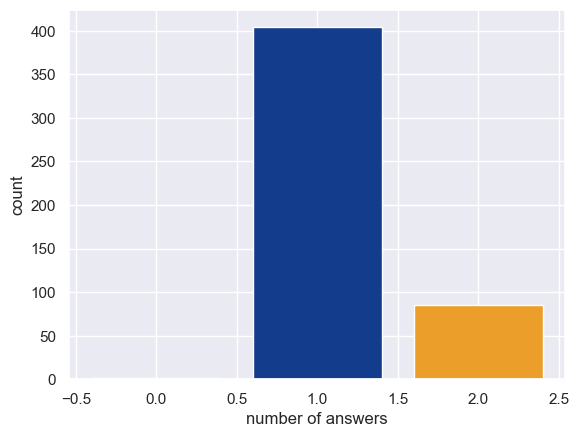

In [4]:
answer_no = evaluation_df.count().tolist()
answer_frequency = Counter(answer_no)
print(answer_frequency)
plt.bar(x=answer_frequency.keys(), height=answer_frequency.values(), color=["#143c8c", "#eb9e2a", "#347cf4"])
plt.ylabel("count")
plt.xlabel("number of answers")
plt.savefig("./data/distribution_of_answers.png", dpi=300, bbox_inches="tight")
plt.show()


##### 1.2.1. Analyze answers with one annotation

In [5]:
evaluation_transposed_df = evaluation_df.T.replace({np.nan: ""})

all_answers = [list(responses) for responses in evaluation_transposed_df.to_numpy()]
answers_dict = dict(zip(range(1, sum(questions_per_file) + 1), all_answers))


In [6]:
annotations = defaultdict(int)
unagg_annotations = defaultdict(str)

for answer_number, answers in answers_dict.items():
    non_null_answers = [answer for answer in answers if answer != ""]
    if len(non_null_answers) == 1:
        if non_null_answers[0]:
            annotations[non_null_answers[0]] += 1
            unagg_annotations[answer_number] = non_null_answers[0]


##### 1.2.2. Analyze answers with two annotations

In [7]:
full_agreement_counter = 0
partial_agreement_counter = 0

for answer_number, answers in answers_dict.items():
    filtered_answers = [answer for answer in answers if answer != ""]

    if len(filtered_answers) == 2:
        if filtered_answers[0] == filtered_answers[1]:
            full_agreement_counter += 1
            annotations[filtered_answers[0]] += 1
            unagg_annotations[answer_number] = filtered_answers[0]
        elif (
            filtered_answers[0] in filtered_answers[1]
            or filtered_answers[1] in filtered_answers[0]
        ):
            partial_agreement_counter += 1
            annotation = " --- partial agreement --- ".join(filtered_answers)
            annotations[annotation] += 1
            unagg_annotations[answer_number] = annotation
        else:
            annotation = " --- disagreement --- ".join(filtered_answers)
            annotations[annotation] += 1
            unagg_annotations[answer_number] = annotation


In [8]:
full_agreement_percentage = full_agreement_counter / answer_frequency[2] * 100
print(
    f"Full agreement percentage between annotators: {round(full_agreement_percentage, 2)}%"
)


Full agreement percentage between annotators: 64.71%


In [9]:
partial_agreement_percentage = partial_agreement_counter / answer_frequency[2] * 100
print(
    f"Partial agreement percentage between annotators: {round(partial_agreement_percentage, 2)}%"
)


Partial agreement percentage between annotators: 15.29%


##### 1.3. Normalize answers

In [10]:
annotations = {
    key: value
    for key, value in sorted(annotations.items(), key=lambda x: x[1], reverse=True)
}
annotations


{'correct answer': 275,
 'incomplete or ambiguous answer': 44,
 'too specific question, correct answer': 21,
 'too specific question': 15,
 'The answer is an interpretation of the information.': 15,
 'irrelevant question, correct answer': 9,
 'wrong answer': 9,
 'too specific question, incomplete or ambiguous answer': 8,
 'correct answer --- disagreement --- incomplete or ambiguous answer': 6,
 'irrelevant question': 4,
 'too specific question, correct answer --- partial agreement --- correct answer': 4,
 'incomplete or ambiguous answer, correct answer': 3,
 'The question is not specific enough.': 3,
 'irrelevant question, incomplete or ambiguous answer': 3,
 'correct answer --- partial agreement --- too specific question, correct answer': 3,
 'The answer contains an assumption.': 2,
 'Based on the information, this is not a relevant question.': 2,
 'incomplete or ambiguous answer, eerste duren iets langer': 2,
 'too specific question, wrong answer': 2,
 'correct answer --- disagreemen

In [11]:
normalized_annotations = defaultdict(int)
recognized_annotations = [
    "irrelevant\nquestion",
    "too specific\nquestion",
    "wrong\nanswer",
    "incomplete or\nambiguous answer",
    "correct\nanswer",
]

for key, value in annotations.items():
    if " --- disagreement --- " not in key:
        found_recognized_annotation = False

        for recognized_annotation in recognized_annotations:
            if recognized_annotation.replace("\n", " ") in key:
                normalized_annotations[recognized_annotation] += value
                found_recognized_annotation = True
                break
        if not found_recognized_annotation:
            normalized_annotations["other"] += value

normalized_annotations = {
    key: value
    for key, value in sorted(
        normalized_annotations.items(), key=lambda x: x[1], reverse=True
    )
}



In [12]:
normalized_annotations

{'correct\nanswer': 278,
 'incomplete or\nambiguous answer': 73,
 'too specific\nquestion': 59,
 'other': 28,
 'irrelevant\nquestion': 22,
 'wrong\nanswer': 12}

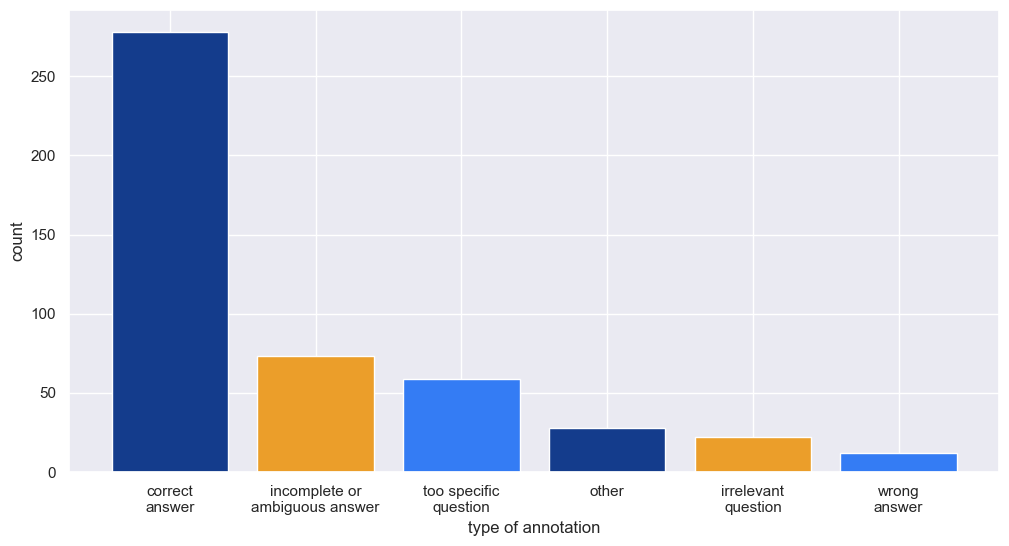

In [13]:
fig, _ = plt.subplots(1, 1)
fig.set_size_inches(12, 6)
plt.bar(
    x=normalized_annotations.keys(),
    height=normalized_annotations.values(),
    color=["#143c8c", "#eb9e2a", "#347cf4"]
)
plt.xlabel("type of annotation")
plt.ylabel("count")

plt.savefig("./data/annotation_results.png", dpi=300, bbox_inches="tight")


##### 1.4. Analyze comments

In [14]:
comments = ""

for key, value in annotations.items():
    cleaned_key = key

    for recognized_annotation in recognized_annotations:
        cleaned_key = cleaned_key.replace(recognized_annotation.replace("\n", " "), "").replace("--- disagreement ---", " ").replace(" --- partial agreement --- ", " ")
    
    cleaned_key = cleaned_key.strip(",").strip().strip(", ")

    if len(cleaned_key) != 0:
        print(cleaned_key)

        comments += cleaned_key + "\n"

The answer is an interpretation of the information.
The question is not specific enough.
The answer contains an assumption.
Based on the information, this is not a relevant question.
eerste duren iets langer
Not enough information in the folder text to know if the chatbot answer is correct.
De vraag en het antwoord is duidelijk, maar misschien kan er bij het antwoord nog toegelicht worden van welke beveiligde verbinding ZGT gebruik maakt.
Er wordt geen antwoord gegeven op wie de volgende afspraak inplant.
Er wordt geen aanbeveling gegeven alleen genoemd dat iedere situatie uniek is.
punt 5 is niet goed.
Not the correct question. The question should be: Kan ik mij bij de fysiotherapie/ergotherapie omkleden en douchen?
The answer contains an assumption.
Based on the information, this is not a relevant question and the answer is an interpretation.
The question is not answered.
Based on the presentation of the information, it's difficult to say if the answeris correct.
The question is not 

In [15]:
with open("./data/comments.txt", "w") as f:
    f.write(comments)

### 2. Get annotations and store annotated data

In [16]:
sections_annotations = copy.deepcopy(unagg_annotations)
recognized_annotations = [
    "irrelevant question",
    "too specific question",
    "wrong answer",
    "incomplete or ambiguous answer",
    "correct answer",
]

for answer_number in unagg_annotations.keys():
    if " --- disagreement --- " not in unagg_annotations[answer_number]:
        found_recognized_annotation = False

        for recognized_annotation in recognized_annotations:
            if recognized_annotation in unagg_annotations[answer_number]:
                sections_annotations[answer_number] = recognized_annotation
                found_recognized_annotation = True
                break
        if not found_recognized_annotation:
            sections_annotations[answer_number] = "other"

    else:
        sections_annotations[answer_number] = "disagreement"

In [17]:
questions_annotations = pd.DataFrame(
    zip(
        [col.split(" --- ")[1].strip() for col in original_columns],
        sections_annotations.values(),
    )
).rename({0: "Question", 1: "Annotation"}, axis=1)
questions_annotations

,Question,Annotation
0,Hoe kan ik de insulinepomptherapie (Patchpomp)...,correct answer
1,Wat is het e-mailadres van Ingrid Pasman?,correct answer
2,Waar kan ik terecht met vragen of problemen?,correct answer
3,Welke informatie wordt verstrekt in de folder ...,correct answer
4,Wie kan ik benaderen voor vragen over de Bryan...,incomplete or ambiguous answer
...,...,...
484,Wat moet ik doen als ik beginnend lymfoedeem heb?,too specific question
485,Waar kan ik ervaringsverhalen lezen en communi...,correct answer
486,Wat zijn mogelijke veranderingen in de litteke...,correct answer
487,Wat is een medische tatoeage en permanente mak...,correct answer


In [18]:
questions_answers_splitted = (
    pd.concat(
        [
            questions_answers["Questions and Answers"].str.split(" --- ", expand=True),
            questions_answers,
        ],
        axis=1,
    )
    .drop([0, "Questions and Answers"], axis=1)
    .rename({1: "Question", 2: "Answer"}, axis=1)
)
questions_answers_splitted["Question"] = questions_answers_splitted["Question"].map(
    lambda x: x.strip()
)
questions_answers_splitted


,Question,Answer,Section
0,Hoe kan ik de insulinepomptherapie (Patchpomp)...,U kunt contact opnemen met de diabetespoli van...,Insulinepomptherapie (Patchpomp) --- Ziekenhui...
1,Wat is het e-mailadres van Ingrid Pasman?,Het e-mailadres van Ingrid Pasman is i.pasman@...,Overzicht van ondersteunende zorg bij kanker-s...
2,Waar kan ik terecht met vragen of problemen?,U kunt altijd bij de verantwoordelijk verpleeg...,Afdeling 5 west (ZGT Almelo) --- Belangrijke i...
3,Welke informatie wordt verstrekt in de folder ...,De folder Borstvoeding na ontslag geeft inform...,Borstvoeding na ontslag uit ZGT --- Borstvoedi...
4,Wie kan ik benaderen voor vragen over de Bryan...,U kunt de verpleegkundige die voor uw kind zor...,Bryant-tractie --- Vragen --- Mocht u nog vrag...
...,...,...,...
485,Waar kan ik ervaringsverhalen lezen en communi...,"U kunt terecht op de website van de Maag, Leve...","Maagkanker, PIM --- 8. Overzicht nuttige websi..."
486,Wat zijn mogelijke veranderingen in de litteke...,"De littekens worden meestal smaller en witter,...","Borstverkleining, borstlift, borstversteviging..."
487,Wat is een medische tatoeage en permanente mak...,Een medische tatoeage en permanente make-up zi...,Medische tatoeage en permanente make-up (ZGT H...
488,Wat zijn de workshops uiterlijke verzorging in...,De workshops uiterlijke verzorging in ZGT zijn...,Overzicht van ondersteunende zorg bij kanker-s...


In [19]:
questions = questions_answers_splitted["Question"].tolist()
assert len(questions) == len(set(questions)), "The questions are not unique."

In [20]:
questions_answers_annotations = questions_answers_splitted.merge(
    questions_annotations, on="Question", how="left"
)
questions_answers_annotations["Question no"] = list(
    range(1, questions_answers_annotations.shape[0] + 1)
)
questions_answers_annotations.set_index("Question no", inplace=True)
questions_answers_correct = questions_answers_annotations[
    questions_answers_annotations["Annotation"] == "correct answer"
].drop("Annotation", axis=1)
questions_answers_correct


,Question,Answer,Section
Question no,,,
1,Hoe kan ik de insulinepomptherapie (Patchpomp)...,U kunt contact opnemen met de diabetespoli van...,Insulinepomptherapie (Patchpomp) --- Ziekenhui...
2,Wat is het e-mailadres van Ingrid Pasman?,Het e-mailadres van Ingrid Pasman is i.pasman@...,Overzicht van ondersteunende zorg bij kanker-s...
3,Waar kan ik terecht met vragen of problemen?,U kunt altijd bij de verantwoordelijk verpleeg...,Afdeling 5 west (ZGT Almelo) --- Belangrijke i...
4,Welke informatie wordt verstrekt in de folder ...,De folder Borstvoeding na ontslag geeft inform...,Borstvoeding na ontslag uit ZGT --- Borstvoedi...
6,Is de slaapspecialist bij de bespreking van de...,Dit kan een andere specialist zijn dan u bij d...,Polysomnografie ambulant (PSG) --- Resultaten ...
...,...,...,...
484,Wat zijn andere mogelijke afwijkingen in de bo...,Andere mogelijke afwijkingen zijn onder andere...,Knobbeltje in de borst --- Veranderingen in de...
486,Waar kan ik ervaringsverhalen lezen en communi...,"U kunt terecht op de website van de Maag, Leve...","Maagkanker, PIM --- 8. Overzicht nuttige websi..."
487,Wat zijn mogelijke veranderingen in de litteke...,"De littekens worden meestal smaller en witter,...","Borstverkleining, borstlift, borstversteviging..."


In [21]:
questions_answers_correct.to_csv(STORAGE_PATH)